In [1]:
import os
from PIL import Image
from skimage import io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [47]:
# Define directories
base_dir = 'brain_tumor_mris'
sub_dirs = ['Testing', 'Training', 'Validation']
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Initialize variables to store minimum width and height
min_width = float('inf')
min_height = float('inf')

# Iterate through all images to find the minimum width and height
for sub_dir in sub_dirs:
    for category in categories:
        path = os.path.join(base_dir, sub_dir, category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                image = io.imread(img_path, as_gray=True)
                height, width = image.shape
                if width < min_width:
                    min_width = width
                if height < min_height:
                    min_height = height
            except Exception as e:
                print(f"Error loading image {img}: {e}")

print(f"Minimum width: {min_width}")
print(f"Minimum height: {min_height}")

#min width 150
#max height 168

KeyboardInterrupt: 

In [48]:
# Define directories
base_dir = 'brain_tumor_mris'
output_dir = 'resized_brain_tumor_mris'
sub_dirs = ['Testing', 'Training', 'Validation']
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create output directories if they don't exist
for sub_dir in sub_dirs:
    for category in categories:
        os.makedirs(os.path.join(output_dir, sub_dir, category), exist_ok=True)

# Function to resize images
def resize_image(image_path, size=(150, 150)):
    with Image.open(image_path) as img:
        # Convert image to RGB if it's in a different mode
        if img.mode != 'RGB':
            img = img.convert('RGB')
        resized_img = img.resize(size)
        return resized_img

# Iterate through all images and resize them
for sub_dir in sub_dirs:
    for category in categories:
        input_path = os.path.join(base_dir, sub_dir, category)
        output_path = os.path.join(output_dir, sub_dir, category)
        for img in os.listdir(input_path):
            try:
                img_path = os.path.join(input_path, img)
                resized_img = resize_image(img_path)
                resized_img.save(os.path.join(output_path, img))  # Save resized image as a copy
            except Exception as e:
                print(f"Error processing image {img}: {e}")

print("All images have been resized to 150x150 pixels and saved as copies.")


KeyboardInterrupt: 

In [2]:
# Define directories
train_dir = 'resized_brain_tumor_mris/Training'
val_dir = 'resized_brain_tumor_mris/Validation'
test_dir = 'resized_brain_tumor_mris/Testing'


In [3]:
class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, name='mean_average_precision', **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Implement the logic to update the state with true positives, false positives, and false negatives
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(predicted_positives - true_positives)
        self.false_negatives.assign_add(possible_positives - true_positives)

    def result(self):
        # Calculate the mean average precision
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        return (precision + recall) / 2.0

    def reset_states(self):
        # Reset the state of the metric
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)




In [4]:
# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
   #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale'
)



model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),


    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(4, activation='softmax')
])



# Compile the model with the custom mAP metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[MeanAveragePrecision()])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    min_lr=0.00000001
)

Found 4672 images belonging to 4 classes.
Found 576 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


C:\Users\Arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Save the model
model.save('brain_tumor_classifier.keras')


Epoch 1/100


C:\Users\Arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


292/292 ━━━━━━━━━━━━━━━━━━━━ 55s 180ms/step - loss: 1.1587 - mean_average_precision: 0.6359 - val_loss: 4.9688 - val_mean_average_precision: 0.4288 - learning_rate: 0.0010
Epoch 2/100
130/292 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - loss: 0.8088 - mean_average_precision: 0.7551

: 

In [69]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5069 - mean_average_precision: 0.8609
Test accuracy: 0.8691046237945557


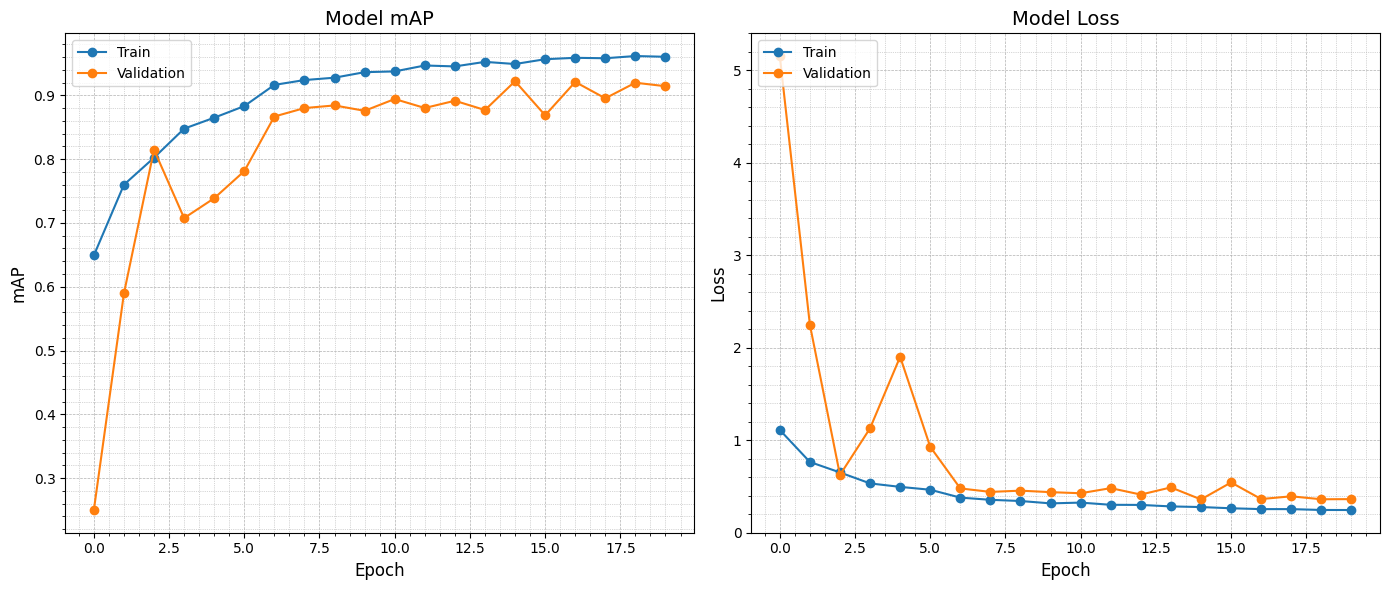

In [78]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Plot mAP
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_average_precision'], marker='o')
plt.plot(history.history['val_mean_average_precision'], marker='o')
plt.title('Model mAP', fontsize=14)
plt.ylabel('mAP', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()
